# Snow Depth Applications

## Author(s)

Karina Zikan, Zach Fair

## Existing Notebooks

[Snow Depth Applications](https://icesat-2-2023.hackweek.io/tutorials/snow-depth/applications-tutorial-snow-depth.html)

## Learning Outcomes

* Gain experience in working with SlideRule to access and pre-process ICESat-2 
data
* Learn how to use projections and interpolation to compare ICESat-2 track data 
with gridded raster products
* Develop a general understanding of how to measure snow depths with LiDAR, 
and learn about opportunities and challenges when using ICEsat-2 along-track
products


## Background
### How do we measure snow depth with LiDAR?
LiDAR is a useful tool for collecting high resolution snow depth maps over large spatial areas.

Snow depth is measured from LiDAR by differencing a snow-free LiDAR map from a snow-covered LiDAR map of the same area of interest.

TODO: Insert Figure 6 from Deems et al. here

TODO: Insert Figure 7b from Deems et al

### Can we do this with ICESat-2?
Yes! By differencing snow-covered ICESat-2 transects from snow-free maps, we can calculate snow depth!

Performing the calculation with ICESat-2 is a little different from other LiDAR snow depth methods, given that ICESat-2 is a transect of points rather than gridded raster data. ICESat-2 also has sparse coverage in the mid-latitudes, so generating an effective snow-covered or snow-free map will be difficult.

Because of these limitations, we need an independently-collected snow-free map of a region of interest for comparison. We also need to process the snow-free data into a form that can be differenced from snow-on ICESat-2 data.

In this tutorial, we will show an example of how to compare ICESat-2 data to raster data.

TODO: Add Karina's image over Dry Creek

### What do we need to calculate snow depth from ICESat-2?
1. A region of interest, where snow-free (and snow-covered, for validation) digital elevation models (DEMs) are available.
2. ICESat-2 data, ideally from one of the lower-level products (ATL03, ATL06, ATL08, Sliderule Earth).
3. A snow-free reference DEM for the snow depth calculation.

### What do we need to consider when comparing ICESat-2 and raster data?
**Geolocation**: To obtain usable results, it is important that we properly align the snow-free raster data with ICESat-2. Even small offsets can create large errors that worsen in rugged terrain.

TODO: Add Figure 9 from Nuth and Kabb

**Vegetation**: Incorrectly categorized vegetation returns can positively bias ground or snow surface height estimation. Additionally, dense vegetation can reduce the number of photon returns, thereby increasing uncertainty in our height estimates.

**Slope Effects**: Rugged terrain increases uncertainty in ICESat-2 returns and increases the impact of geolocation offsets between ICESat-2 and raster data. Additionally, steep slopes can negatively bias ground or snow surface height estimates.

### Computing Environment
We'll be using the following open source Python libraries in this notebook:

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from sliderule import icesat2
from scipy.interpolate import RectBivariateSpline

### Data
We will use SlideRule to acquire customized ATL06 data. Specific customizations that we will implement include footprint averaging (i.e., along-track sampling rate) and photon identification (signal/noise and ground/vegetation).

We will look at snow depth data over Upper Kuparuk/Toolik (UKT) on the Arctic North Slope of Alaska. Because UKT is a relatively flat region with little vegetation, we should expect good agreement between ICESat-2 and our rasters of interest.

### Initialize SlideRule

In [2]:
icesat2.init("slideruleearth.io")

### Define Region of Interest
After we initialize SlideRule, we define our region of interest. Notice that there are two options given below. This is because SlideRule accepts either the coordinates of a box/polygon or a geoJSON for its `region` input.

We are going to use the bounding box method in this tutorial, but the syntax for the geoJSON method is included for the user's reference.

In [3]:
# Define region of interest over Toolik, Alaska
region = [{"lon":-149.5992624418217, "lat":68.63358948385529}, 
          {"lon":-149.5954459662985, "lat":68.60200878043223}, 
          {"lon":-149.2821268688734, "lat":68.60675802967609}, 
          {"lon":-149.2855031235162, "lat":68.63834638180673},
          {"lon":-149.5992624418217, "lat":68.63358948385529}]

print(region)

[{'lon': -149.5992624418217, 'lat': 68.63358948385529}, {'lon': -149.5954459662985, 'lat': 68.60200878043223}, {'lon': -149.2821268688734, 'lat': 68.60675802967609}, {'lon': -149.2855031235162, 'lat': 68.63834638180673}, {'lon': -149.5992624418217, 'lat': 68.63358948385529}]


In [ ]:
# Alternate method, with geoJSON
path = "/path/to/geojson/"
region = sliderule.toregion(path)["poly"]
print(region)

### Build SlideRule Request
Now we are going to build our SlideRule request by defining ICESat-2 parameters.

Since we want something close to the ATL06 product, we will use the `icesat2.atl06p()` function in this tutorial. You can find other SlideRule functions and more detail on the `icesat2.atl06p()` function on the SlideRule API reference. (TODO: Add link to API reference)

We won't use every parameter in this tutorial, but here is a reference list for some of them. More information can be found in the SlideRule users guide (TODO: Add link to users guide)

```{note}
**Parameters**
* `poly`: Polygon defining region of interest.
* `track`: Reference pair track number (1, 2, 3; 0 to include all three; defaults to 0).
* `rgt`: Reference ground track (defaults to all).
* `cycle`: Counter of 91-day repeat cycles completed by the mission (defaults to all).
* `region`: Geographic region for data product (defaults to global).
* `t0`: Start time for filtering granules (%Y-%m%dT%h:%M:%SZ format)
* `t1`: Stop time for filtering granules (%Y-%m%dT%h:%M:%SZ format).
* `srt`: Surface type (0=land, 1=ocean, 2=sea ice, 3=land ice, 4=inland water).
* `cnf`: Confidence level for photon selection, in integer or list format.
* `atl08_class`: List of ATL08 classifications for photon processing (“atl08_noise”, “atl08_ground”, “atl08_canopy”, “atl08_top_of_canopy”, “atl08_unclassified”).
* `maxi`: Maximum interations of algorithm, not including initial least-squares-fit selection.
* `H_min_win`: Minimum height to which the refined photon-selection window is allowed to shrink, in meters.
* `sigma_r_max`: Maximum robust spread (uncertainty) in meters.
* `compact`: Return results without most metadata.
```

In [5]:
## Build SlideRule request
# Define parameters (described below)
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "atl08_class": ["atl08_ground"],
    "ats": 5.0,
    "len": 20.0,
    "res": 10.0,
    "maxi": 5
}

# Calculated ATL06 dataframe
is2_df = icesat2.atl06p(parms)

# Print SlideRule output
print(is2_df.head())

                                     y_atc      x_atc  dh_fit_dx  cycle  spot  \
time                                                                            
2018-10-20 00:56:22.190402560 -4502.958984  7650522.0   0.051936      1     2   
2018-10-20 00:56:22.191812864 -4502.944824  7650532.0  -0.026959      1     2   
2018-10-20 00:56:22.193223680 -4502.937012  7650542.0  -0.011005      1     2   
2018-10-20 00:56:22.194635776 -4502.930664  7650552.0  -0.010565      1     2   
2018-10-20 00:56:22.196046080 -4502.927734  7650562.0  -0.019765      1     2   
...                                    ...        ...        ...    ...   ...   
2025-02-04 11:06:09.214216192  3295.494873  7654039.0   0.041633     26     1   
2025-02-04 11:06:09.217046272  3295.409424  7654059.0   0.056376     26     1   
2025-02-04 11:06:09.218464256  3295.363281  7654069.0   0.077897     26     1   
2025-02-04 11:06:09.221302784  3295.267822  7654089.0   0.055931     26     1   
2025-02-04 11:06:09.22272230

```{note}
We defined our `region` above, so let's run through the remaining parameters in our query:

* `srt`: Only land photons will be considered.
* `cnf`: Only high-confidence photons.
* `atl08_class`: Only ground photons, as identified by the ATL08 algorithm.
* `ats`: The maximum along-track spread (uncertainty) in aggregated photons will be 5 m.
* `len`: The length of each segment of aggregated photons will be 20 m.
* `res`: The along-track resolution will be 10 m. Because each segment will be 20 m long, there will be overlap between successive data points.
* `maxi`: The SlideRule refinement algorithm will iterate 5 times per segment at maximum.

### Subsetting the Data

One may notice that the algorithm took a long time to generate the GeoDataFrame. That is because (i) our region of interest was rather large and (ii) we obtained all ICESat-2 tracks in the ROI since its launch (2018).

For the sake of interest, let's take a look at all of the ICESat-2 tracks over Upper Kuparuk/Toolik.

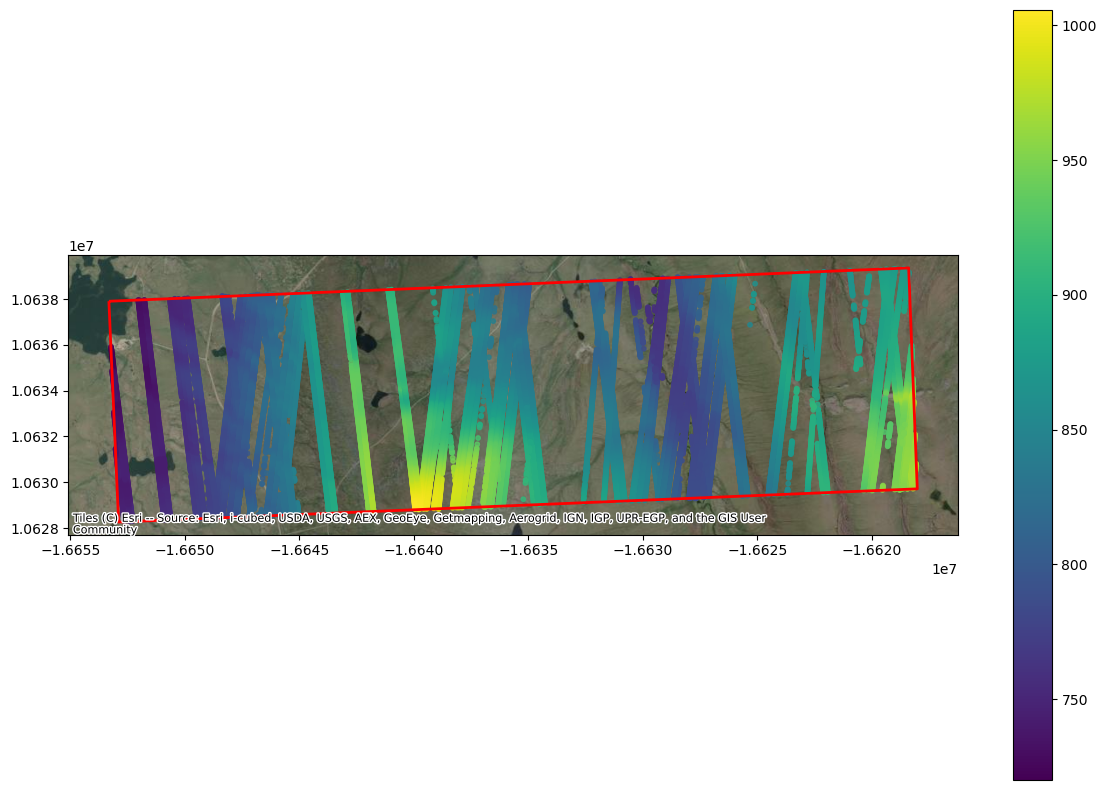

In [27]:
import contextily as ctx
from shapely.geometry import Polygon

# Convert region to a Polygon
coords = [(point["lon"], point["lat"]) for point in region]
polygon = Polygon(coords)
region_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4326")

# Reproject to Web Mercator for contextily
is2_df_mercator = is2_df.to_crs(epsg=3857)
region_mercator = region_gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 8))
# Plot surface height
is2_df_mercator.plot(column='h_mean', 
                  ax=ax, 
                  cmap='viridis',
                  legend=True,
                  markersize=10,
                  alpha=0.8)

# Plot the region bounding box
region_mercator.plot(ax=ax, 
                     facecolor='none', 
                     edgecolor='red', 
                     linewidth=2)

# Add ESRI World Imagery basemap
ctx.add_basemap(ax, 
                crs=is2_df_mercator.crs, 
                source=ctx.providers.Esri.WorldImagery)
plt.tight_layout()
plt.show()

It is cool to see all of the available data, but we only have snow-free lidar DEMs available from March 2022. So, we are going to subset the data to include one ICESat-2 track (**RGT 152**) in **March 2023**.

In [32]:
# Subset ICESat-2 data to single RGT, time of year
is2_df_subset = is2_df[is2_df['rgt']==152]
is2_df_subset = is2_df_subset.loc['2023-03-31']

# Display top of dataframe
print(is2_df_subset.head())

                   y_atc       x_atc  dh_fit_dx  cycle  spot  segment_id  \
time                                                                       
2023-03-31 -20939.156250  12418799.0  -0.047823     19     1      620001   
2023-03-31 -20939.173828  12418809.0  -0.053057     19     1      620002   
2023-03-31 -20939.193359  12418819.0  -0.073967     19     1      620002   
2023-03-31 -20939.203125  12418829.0  -0.032487     19     1      620003   
2023-03-31 -20939.205078  12418839.0  -0.048137     19     1      620003   

            region   h_sigma  pflags  w_surface_window_final  n_fit_photons  \
time                                                                          
2023-03-31       5  0.036000       0                     3.0             51   
2023-03-31       5  0.038032       0                     3.0             52   
2023-03-31       5  0.041716       0                     3.0             41   
2023-03-31       5  0.050364       0                     3.0            

## Sample the Lidar DTM to ICESat-2 ground track

The ICESat-2 data is ready to go! Now it's time to load the airborne lidar data, and co-register it with ICESat-2.

The lidar data used here is from the University of Alaska, Fairbanks (UAF). The UAF lidar obtains snow-on and snow-off DEMs/digital terrain models (DTMs) with a 1064 nm (near-infrared) laser, from which it can also derive snow depth.

UAF lidar rasters normally have a spatial resolution of 0.5 m, which can take a long time to process. As a compromise between computation speed and resolution, we will coarsen the rasters to 3 m resolution.

The best way to handle lidar DEMs/DTMs is through `rioxarray`:

In [ ]:
# File paths for UAF rasters (TODO: Add lidar files, and update names)
tifpath = "/your/path/here"
f_snow_off = f"{tifpath}/uaf_lidar_snowoff.tif"
f_snow_on = f"{tifpath}/uaf_lidar_snowon.tif"

# Load files as rioxarray datasets
lidar_snow_off = rxr.open_rasterio(f_snow_off)
lidar_snow_on = rxr.open_rasterio(f_snow_on)

It is not immediately obvious, but the uAF rasters are in a different spatial projection than ICESat-2. UAF is in **EPSG:32606**, and ICESat-2 is in **WGS84/EPSG:4326**.

In order to directly compare these two datasets, we are going to add reprojected coordinates to the ICESat-2 GeoDataFrame. In essence, we will go from **latitude/longitude** to **northing/easting**. Luckily, there is an easy way to do this with GeoPandas, specifically with the `geopandas.to_crs()` function.

In [ ]:
# Initialize ICESat-2 coordinate projection
is2_df_subset = is2_df_subset.set_crs("EPSG:4326")

# Change to EPSG:32606
is2_df_subset = is2_df_subset.to_crs("EPSG:32606")

# Display top of dataframe
print(is2_df_subset.head())

### Co-register rasters and ICESat-2
Now, we are going to co-register both rasters to the queried ICESat-2 data. The function below is fairly long, but the gist is that we a re using a spline interpolant to match both the snow-off UAF data (surface height) and UAF snow depths with ICESat-2 surface heights. The resulting GeoDataFrame will have both ICESat-2 and UAF data in it.

In [33]:
# Make coregistration function
def coregister_is2(lidar_snow_off, lidar_snow_on, is2_df):
    """
    Co-registers UAF data with ICESat-2 data with a rectangular 
    bivariate spline.

    Parameters
    ------------
    lidar_snow_off: rioxarray dataset
        Lidar DEM/DTM in rioxarray format.
    lidar_snow_on: rioxarray dataset
        Lidar-derived snow depth in rioxarray format.
    is2_df: GeodataFrame
        GeoDataFrame for the ICESat-2 data generated with SlideRule.

    Returns
    ------------
    is2_uaf_df: GeoDataFrame
        Contains the coordinate and elevation data that matches best
        between ICESat-2 and UAF.
    """

    # Helper function to prepare lidar data
    def prepare_lidar_data(raster):
        coords_x = np.array(raster.x)
        coords_y = np.array(raster.y)
        values = np.array(raster.sel(band=1))[::-1, :]
        values[np.isnan(values)] = -9999
        return coords_x, coords_y, values

    # Get coordinates and height/depth values from lidar data
    x0, y0, dem_heights = prepare_lidar_data(lidar_snow_off)
    xs, ys, dem_depths = prepare_lidar_data(lidar_snow_on)

    # Generate interpolators
    interp_height = RectBivariateSpline(y0[::-1], x0, dem_heights)
    interp_height = RectBivariateSpline(ys[::-1], xs, dem_depths)

    # Pre-filter IS2 data to bounds (apply once instead of per beam)
    x_bounds = (is2_df.geometry.x > np.min(x0)) & (is2_df.geometry.x < np.max(x0))
    y_bounds = (is2_df.geometry.y > np.min(y0)) & (is2_df.geometry.y < np.max(y0))
    is2_filtered = is2_df[x_bounds & y_bounds].copy()

    if is2_filtered.empty:
        print('Error with GeoDataFrame or raster bounds.')
        return gpd.GeoDataFrame()

    # Extract coordinates once
    xn = is2_filtered.geometry.x.values
    yn = is2_filtered.geometry.y.values

    # Estimate lidar height and snow depth at the ICESat-2 coordinates
    lidar_heights = interp_height(yn, xn, grid=False)
    lidar_snow_depths = interp_depth(yn, xn, grid=False)

    # Create result DataFrame in one operation
    is2_uaf_df = gpd.GeoDataFrame({
        'x': xn,
        'y': yn,
        'time': is2_filtered.index.values,
        'beam': is2_filtered['gt'].values,
        'lidar_height': lidar_heights,
        'lidar_snow_depth': lidar_snow_depths,
        'is2_height': is2_filtered['h_mean'].values,
        'h_sigma': is2_filtered['h_sigma'].values,
        'dh_fit_dx': is2_filtered['dh_fit_dx'].values
    })

    # Add coordinate transformation
    transformer = Transformer.from_crs("EPSG:32606", "EPSG:4326", always_xy=True)
    is2_uaf_df['lon'], is2_uaf_df['lat'] = transformer.transform(
        is2_uaf_df['x'], is2_uaf_df['y']
    )

    return is2_uaf_df